In [1]:
from pandas import Series
import pandas as pd
import numpy as np
from random import uniform, seed
import math
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix, f1_score

from datetime import datetime, timedelta

from sklearn.model_selection import GridSearchCV

RANDOM_SEED = 42

pd.set_option('max_colwidth', 100)

# Helper functions

In [2]:
def mass_countplot(data, lst, include_target=False):
    """
    Performs a mass countplot visualization based on a 
    dataframe (data) and a list of variables (lst).
    
    If include_target is False then target variable is not included.
    Otherwise, pass the target variable name and it will be included.
    """
    
    tmp_lst = lst.copy()
    
    if include_target:
        tmp_lst.append(include_target)
            
    for col in tmp_lst:
        try:
            # Just to show if a column has missing values
            has_nan = data[col].value_counts(dropna=False)[np.nan]
            msg = f"Column {col} contains {has_nan} missing values"
        except:
            msg=''
        fig = plt.figure()
        fig.suptitle(msg)
        sns.countplot(x=data[col])

def fillna_freq(freq):
    """
    Replaces a missing value based on a frequency of other values
    in this column
    """
    seed(RANDOM_SEED)
    rnd = round(uniform(0,1),2)
    result = freq[freq <= rnd].index[-1]
    #print(f"Random value {rnd} corresponds to {result}")
    return result

def get_date_features(d):
    """
    Converts string representation of date to datetime and extracts
    date-related features
    """
    dt = datetime.strptime(d,'%d%b%Y')
    is_weekend = 0
    is_end_of_month = 0
    
    # 5 and 6 are Saturday and Sunday
    if dt.weekday() >= 5:
        is_weekend = 1
    
    # let's consider all the days after 25 an end of month 
    if dt.day > 25:
        is_end_of_month = 1
    
    return [is_weekend, is_end_of_month, dt.strftime("%B"), dt.weekday(), math.ceil(dt.month/3.)]

def mass_hist(data, lst, to_log=False, iqr=False):
    """
    Creates a histogram for each numeric variable (passed in lst)
    for the data set (passed in data).
    
    If logarithm needs to be applied then to_log must be set to True
    
    If iqr=True then the data about outliers will be displayed
    """
    for i in lst:
        plt.figure()
        if to_log:
            sns.distplot(np.log(data[i][data[i] > 0].dropna()), kde = False, rug=False)
        else:
            sns.distplot(data[i], kde = False, rug=False)
        if iqr:
            print(get_iqr_flexible(data[i]))
        plt.title(i)
        plt.show()
        
def mass_box(data, lst):
    """
    Same as mass_hist, but draws box plots instead
    """
    for i in lst:
        plt.figure()
        print(f"Average {i} values : {data.groupby('default')[i].mean()}")
        sns.boxplot(data = data, y=i, x='default', showmeans=True)
        plt.title(i)
        plt.show()
        
def get_iqr_flexible(s, low_perc=0.25, high_perc=0.75):
    """
    Returns some basic statistics related to IQR.
    It's flexible because by default this function
    delivers 25, 50, 75 percentiles and IQR, however,
    if you set a different low_perc and high_perc values 
    ther results will be different.

    Of course, if you, for example, set low_perc = 0.1
    and high_perc = 0.9 the result won't actually be IQR
    anymore because it will have nothing to do with quartiles. 
    Name IQR is used here just for convenience and becauss in
    most cases standard will be used anyway.
    """
    median = s.median()
    iqr = s.quantile(0.75) - s.quantile(0.25)
    perc25 = s.quantile(0.25)
    perc75 = s.quantile(0.75)
    lower_outliers = Counter(s[(s < perc25 - 1.5*iqr)])
    higher_outliers = Counter(s[(s > perc75 + 1.5*iqr)])
    print(
        f'Column name: {s.name}. Median: {median}. Lower percentile ({low_perc}): {perc25}.')
    print(
        f'Higher percentile ({high_perc}): {perc75}. IQR: {iqr}.')
    print(
        f'Lower outliers: {lower_outliers}.')
    print(
        f'Higher outliers: {higher_outliers}.')
    return {'perc25': perc25, 'median': median, 'perc75': perc75, 'iqr': iqr}     

def print_roc_curve(y_true, y_pred_probs):
    """
    Draws a ROC curve (this function will be reused)
    """
    fpr, tpr, threshold = roc_curve(y_true, y_pred_probs)
    roc_auc = roc_auc_score(y_true, y_pred_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
def print_confusion_matrix(y_true, y_pred_values):
    """
    Draws confusion matrix (this function will be reused)
    """
    conf_matrix = confusion_matrix(y_true, y_pred_values)
    print(conf_matrix)
    print(f"F-1 score: {f1_score(y_true, y_pred_values)}")
    
    ax= plt.subplot()
    sns.heatmap(conf_matrix, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Non-default', 'Default']); ax.yaxis.set_ticklabels(['Non-default', 'Default'])        

# Reading and exploring data

In [3]:
# Reading both train and test dataframes and concatenating them
# for common data pre-processing operations. 
# Column 'label' is added to differentiate between test and train 
# datasets later
train = pd.read_csv('../input/sf-dst-scoring/train.csv')
train['label'] = 'train'
test = pd.read_csv('../input/sf-dst-scoring/test.csv')
test['label'] = 'test'
data = pd.concat([train,test])
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,label
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,train
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,train
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,train
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,train
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,train


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        110

In [5]:
# 1) Only education has missing values - I will deal with it later
# 2) Field app_date represents an application date. It doesn't provide any useful information by default, but after being processed it can generate new interesting features. I will deal with it later.
# 3) Field client_id will most likely not be used for prediction. However, it will be required for checking the result of a model.
# 4) Categorical variables are listed below. Some of them might be binary, but I will separate them only after visualisation (when I will be sure they are in fact binary).
cat_vars = ['education', 'sex', 'car', 'car_type', 'good_work', 'home_address', 'work_address', 'sna', 'foreign_passport', 'first_time', 'region_rating']

# 5) Numeric variables are listed below
num_vars = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

# 6) Target variable is default
target = 'default'

# Categorical variables

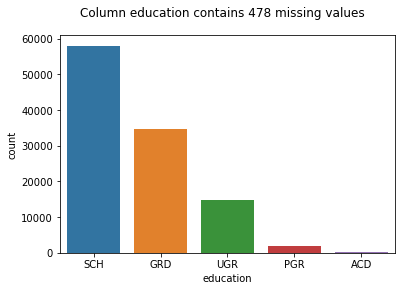

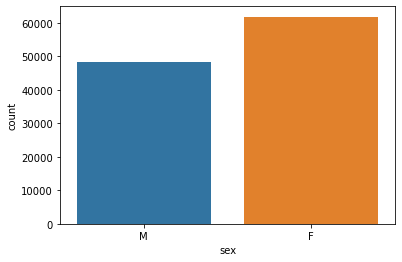

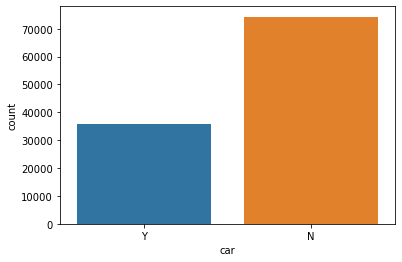

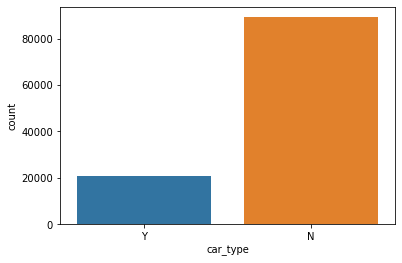

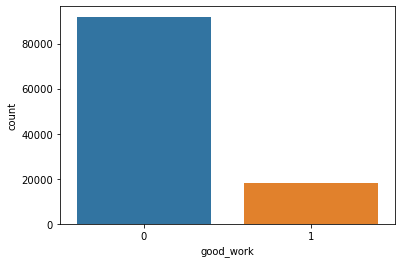

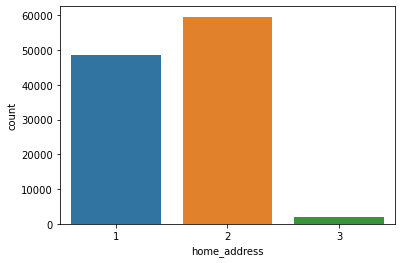

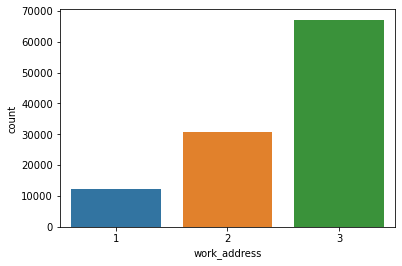

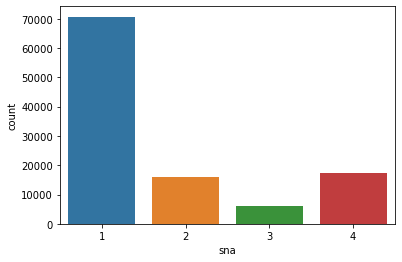

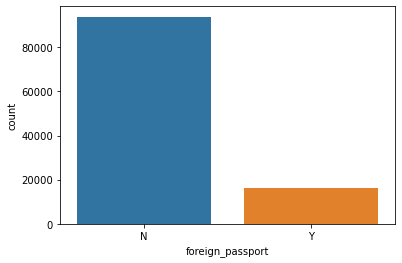

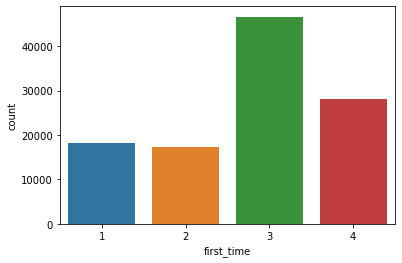

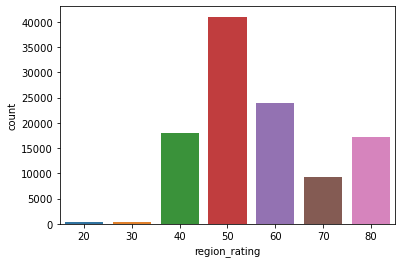

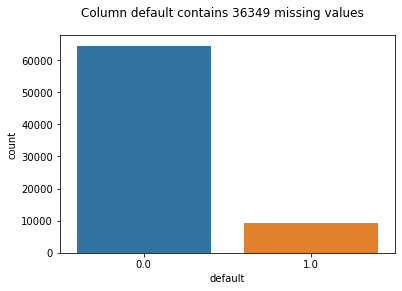

In [6]:
# Let's visualize categorical variables (please scroll down to see the whole result
# because there are multiple charts in the result of this cell)
mass_countplot(data, cat_vars, target)

In [7]:
# Variables 'sex', 'car', 'car_type', 'good_work', 'foreign passport' are in fact binary. 
# Let's separate them for convenience
bin_vars = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# And remove them from cat_vars
cat_vars = list(set(cat_vars) - set(bin_vars))
print(cat_vars)

['sna', 'region_rating', 'home_address', 'first_time', 'work_address', 'education']


In [8]:
# Column education has 478 missing values. Let's replace them based on the
# frequency of other values to make the replacement fair
edu_freq = data['education'].value_counts(normalize=True, ascending=True).round(2)
edu_freq

ACD    0.00
PGR    0.02
UGR    0.13
GRD    0.32
SCH    0.53
Name: education, dtype: float64

In [9]:
# Mapping a custom function fillna_freq to perform this
# operation. As a result there are no more missing values in education
data['education'] = data['education'].map(lambda x: fillna_freq(edu_freq) if pd.isna(x) else x)
data['education'].value_counts(dropna=False)

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [10]:
# Let's do something with app_date. Custom function will be used to extract 
# new features. Features will be written in a list and then separated into columns
data['date_feature_lst'] = data['app_date'].map(lambda x: get_date_features(x))
data[['is_weekend','is_end_of_month', 'month', 'weekday', 'quarter']] = data['date_feature_lst'].tolist()
data.drop(labels=['date_feature_lst','app_date'], inplace=True, axis=1)
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,sna,first_time,foreign_passport,default,label,is_weekend,is_end_of_month,month,weekday,quarter
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,...,4,1,N,0.0,train,1,0,February,5,1
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,...,4,1,N,0.0,train,0,0,March,2,1
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,...,1,4,Y,0.0,train,1,0,February,5,1
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,...,1,3,N,0.0,train,0,0,January,3,1
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,...,1,4,Y,0.0,train,0,0,April,4,2


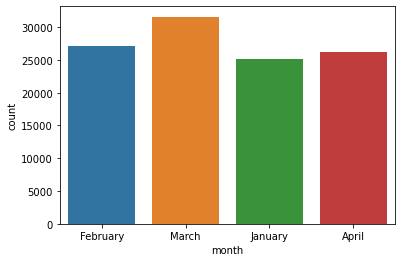

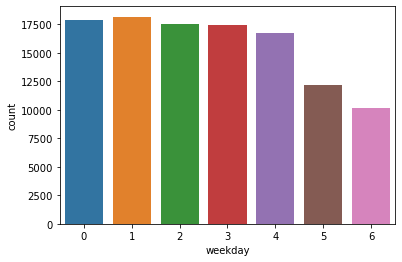

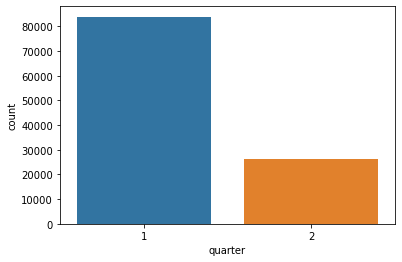

In [11]:
# Let's visualize new columns.
mass_countplot(data, ['month','weekday','quarter'])

In [12]:
# Let's add 'weekday' to categorical features and 'is_weekend','is_end_of_month'
# to binary features. month and quarter will be added to categorical variables
bin_vars.extend(['is_weekend','is_end_of_month'])
cat_vars.extend(['weekday','month','quarter'])
print(bin_vars)
print(cat_vars)

['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'is_weekend', 'is_end_of_month']
['sna', 'region_rating', 'home_address', 'first_time', 'work_address', 'education', 'weekday', 'month', 'quarter']


In [13]:
# Binary variables (columns 'sex', 'car', 'car_type', 'foreign_passport') need to be label encoded
label_encoder = LabelEncoder()

for var in bin_vars:
    data[var] = label_encoder.fit_transform(data[var])
    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,sna,first_time,foreign_passport,default,label,is_weekend,is_end_of_month,month,weekday,quarter
0,25905,SCH,1,62,1,1,0,0,-2.008753,1,...,4,1,0,0.0,train,1,0,February,5,1
1,63161,SCH,0,59,0,0,0,0,-1.532276,3,...,4,1,0,0.0,train,0,0,March,2,1
2,25887,SCH,1,25,1,0,2,0,-1.408142,1,...,1,4,1,0.0,train,1,0,February,5,1
3,16222,SCH,0,53,0,0,0,0,-2.057471,2,...,1,3,0,0.0,train,0,0,January,3,1
4,101655,GRD,1,48,0,0,0,1,-1.244723,1,...,1,4,1,0.0,train,0,0,April,4,2


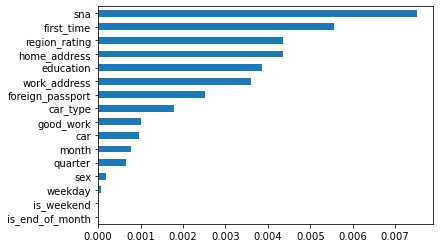

In [14]:
# Let's see what categorical variables look important. For that we need to label encode categorical variables
# (non-binary) as well. I will do it in a separate dataframe to avoid messing with the original one.
tmp_data = data[data['label']=='train'].copy()

for var in cat_vars:
    tmp_data[var] = label_encoder.fit_transform(tmp_data[var])

imp_cat = Series(mutual_info_classif(tmp_data[bin_vars + cat_vars], tmp_data['default'],
                                     discrete_features =True), index = bin_vars + cat_vars)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [15]:
# Let's drop i'is_weekend','is_end_of_month', 'weekday', 'sex', 'quarter' as they don't appear to be significant.
data.drop(labels=['is_weekend','is_end_of_month', 'weekday', 'sex', 'quarter'], axis=1, inplace=True)
bin_vars.remove('is_weekend')
bin_vars.remove('is_end_of_month')
bin_vars.remove('sex')
cat_vars.remove('weekday')
cat_vars.remove('quarter')

In [16]:
# Categorical variables need to be one hot encoded
# Drop first is used to make the model learn faster and to avoid
# multicollinearity
data = pd.get_dummies(data, prefix=cat_vars, columns=cat_vars, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   age               110148 non-null  int64  
 2   car               110148 non-null  int64  
 3   car_type          110148 non-null  int64  
 4   decline_app_cnt   110148 non-null  int64  
 5   good_work         110148 non-null  int64  
 6   score_bki         110148 non-null  float64
 7   bki_request_cnt   110148 non-null  int64  
 8   income            110148 non-null  int64  
 9   foreign_passport  110148 non-null  int64  
 10  default           73799 non-null   float64
 11  label             110148 non-null  object 
 12  sna_2             110148 non-null  uint8  
 13  sna_3             110148 non-null  uint8  
 14  sna_4             110148 non-null  uint8  
 15  region_rating_30  110148 non-null  uint8  
 16  region_rating_40  110

In [17]:
data.head()

,client_id,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,...,first_time_4,work_address_2,work_address_3,education_GRD,education_PGR,education_SCH,education_UGR,month_February,month_January,month_March
0,25905,62,1,1,0,0,-2.008753,1,18000,0,...,0,1,0,0,0,1,0,1,0,0
1,63161,59,0,0,0,0,-1.532276,3,19000,0,...,0,0,1,0,0,1,0,0,0,1
2,25887,25,1,0,2,0,-1.408142,1,30000,1,...,1,1,0,0,0,1,0,1,0,0
3,16222,53,0,0,0,0,-2.057471,2,10000,0,...,0,0,1,0,0,1,0,0,1,0
4,101655,48,0,0,0,1,-1.244723,1,30000,1,...,1,0,1,1,0,0,0,0,0,0


# Numeric variables

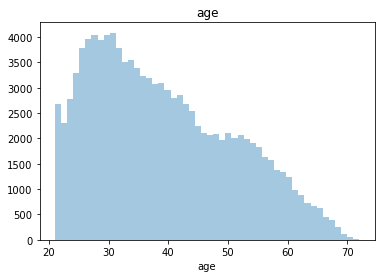

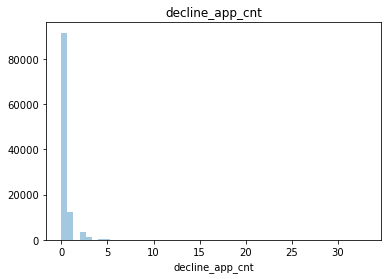

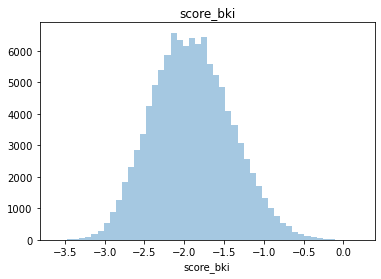

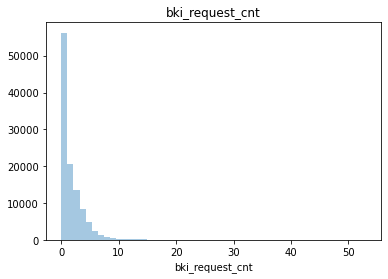

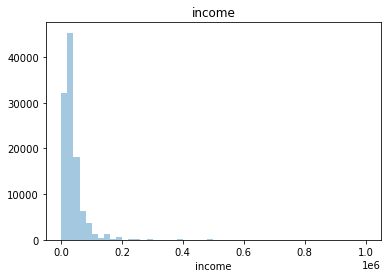

In [18]:
# First visualization of numeric variables (please scroll down because there 
# are multiple charts in a result of this cell).

# 1) Some distributions look skewed. I can apply log to these variables later.
# 2) Apart from that, numeric variables will need to be scaled later as well.

mass_hist(data, num_vars)

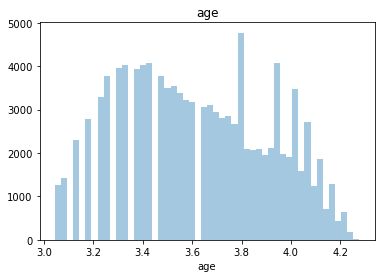

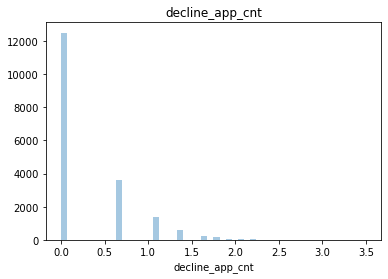

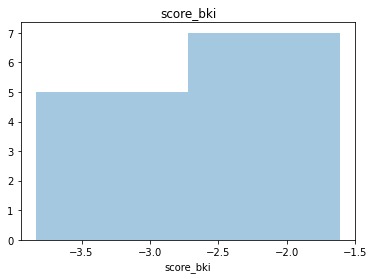

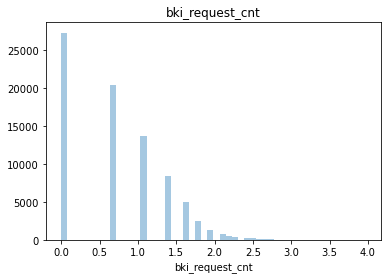

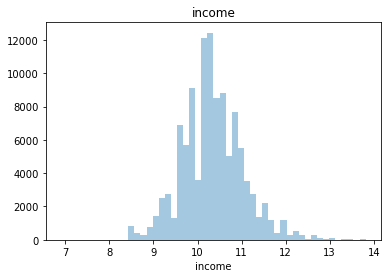

In [19]:
# Example of how numeric variables will look like this after
# applying log is below (most likely the most positive impact will be on
# age and income)
mass_hist(data, num_vars, to_log=True)

Average age values : default
0.0    39.390504
1.0    38.525395
Name: age, dtype: float64


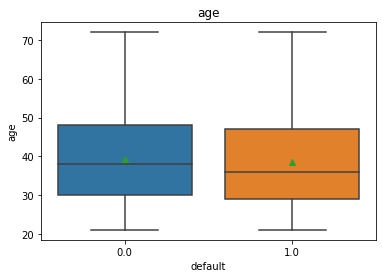

Average decline_app_cnt values : default
0.0    0.240877
1.0    0.515472
Name: decline_app_cnt, dtype: float64


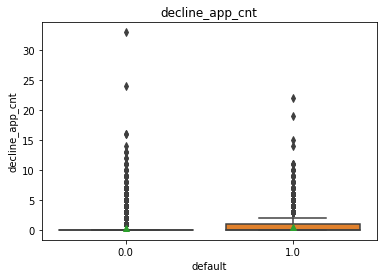

Average score_bki values : default
0.0   -1.938048
1.0   -1.675637
Name: score_bki, dtype: float64


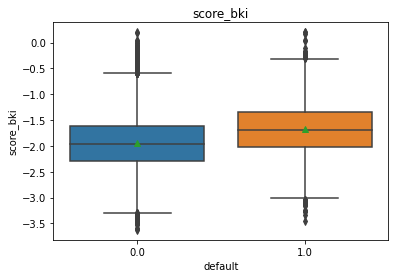

Average bki_request_cnt values : default
0.0    1.933134
1.0    2.462335
Name: bki_request_cnt, dtype: float64


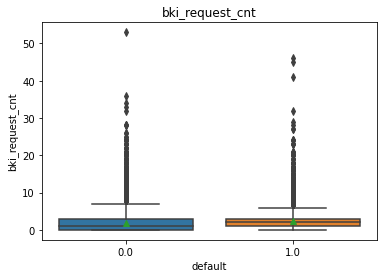

Average income values : default
0.0    41799.713288
1.0    36288.113316
Name: income, dtype: float64


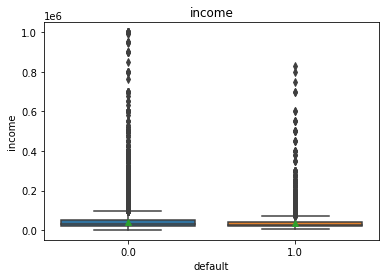

In [20]:
# Let's draw box plots as well (pleae scroll down becasue there are multiple charts
# and average outputs in result cell below).

# Difference in average value of some variables grouped by "default" suggests
# that these variables might be significant for further analysis. This, however,
# will be established later using statistical method.
mass_box(data, num_vars)

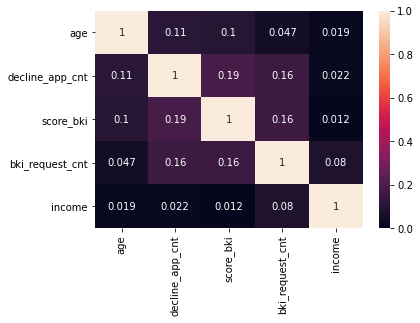

In [21]:
# From the heatmap based on a correlation matrix we can see that
# there are no strongly correlated numeric variables.
sns.heatmap(data[num_vars].corr().abs(), vmin=0, vmax=1, annot=True)

In [22]:
data[num_vars].corr().abs()

,age,decline_app_cnt,score_bki,bki_request_cnt,income
age,1.000000,0.111454,0.104682,0.046975,0.018664
decline_app_cnt,0.111454,1.000000,0.187869,0.159927,0.022241
score_bki,0.104682,0.187869,1.000000,0.157451,0.011721
bki_request_cnt,0.046975,0.159927,0.157451,1.000000,0.080475
income,0.018664,0.022241,0.011721,0.080475,1.000000


In [23]:
# let's apply log to some of numeric variables
data['age'] = np.log(data['age']+1)
data['income'] = np.log(data['income']+1)

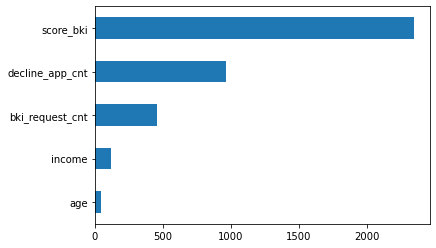

In [24]:
# Let's check the significance of numeric variables.
# Looks like there are new potentially strong predictors like score_bki
# (comparing to the baseline version)
imp_num = Series(f_classif(train[num_vars], train['default'])[0], index = num_vars)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [25]:
# Let's standartize numeric variables
st_scaler = StandardScaler()
data[num_vars] = pd.DataFrame(st_scaler.fit_transform(data[num_vars]),columns = data[num_vars].columns)
data.drop(labels=num_vars, inplace=True, axis=1)
data.head()

,client_id,car,car_type,good_work,foreign_passport,default,label,sna_2,sna_3,sna_4,...,first_time_4,work_address_2,work_address_3,education_GRD,education_PGR,education_SCH,education_UGR,month_February,month_January,month_March
0,25905,1,1,0,0,0.0,train,0,0,1,...,0,1,0,0,0,1,0,1,0,0
1,63161,0,0,0,0,0.0,train,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2,25887,1,0,0,1,0.0,train,0,0,0,...,1,1,0,0,0,1,0,1,0,0
3,16222,0,0,0,0,0.0,train,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,101655,0,0,1,1,0.0,train,0,0,0,...,1,0,1,1,0,0,0,0,0,0


# Modelling

In [26]:
# After all the processing is done, let's split the dataframe back to train and test
train = data[data['label']=='train'].copy()
test = data[data['label']=='test'].copy()
train.drop(['label','client_id'], axis=1, inplace=True)
test.drop('label', axis=1, inplace=True)

In [27]:
test.head()

,client_id,car,car_type,good_work,foreign_passport,default,sna_2,sna_3,sna_4,region_rating_30,...,first_time_4,work_address_2,work_address_3,education_GRD,education_PGR,education_SCH,education_UGR,month_February,month_January,month_March
0,74835,1,1,0,0,NaN,0,0,0,0,...,1,1,0,1,0,0,0,0,0,1
1,17527,0,0,0,0,NaN,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
2,75683,1,1,0,1,NaN,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
3,26883,0,0,0,0,NaN,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
4,28862,0,0,0,0,NaN,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0


In [28]:
train.head()

,car,car_type,good_work,foreign_passport,default,sna_2,sna_3,sna_4,region_rating_30,region_rating_40,...,first_time_4,work_address_2,work_address_3,education_GRD,education_PGR,education_SCH,education_UGR,month_February,month_January,month_March
0,1,1,0,0,0.0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,0,0,0,0,0.0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
2,1,0,0,1,0.0,0,0,0,0,0,...,1,1,0,0,0,1,0,1,0,0
3,0,0,0,0,0.0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,0,0,1,1,0.0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0


In [29]:
Y = train['default']
X = train.drop('default', axis=1, inplace=False)

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

In [31]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_valid = model.predict_proba(X_valid)
y_pred_valid_values = model.predict(X_valid)
y_pred_valid
probs_valid_default = y_pred_valid[:,1]

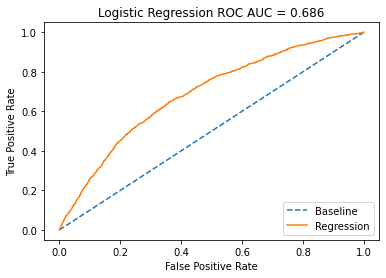

In [32]:
print_roc_curve(y_valid, probs_valid_default)

[[12933     0]
 [ 1827     0]]
F-1 score: 0.0


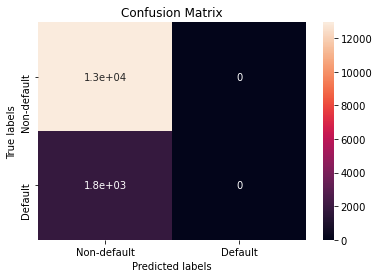

In [33]:
print_confusion_matrix(y_valid, y_pred_valid_values)

**Looks like the model is not really great even though ROC AUC is higher than the baseline. Confusion matrix shows that I've missed default cases. F-1 score represents that in a numeric way.**

In [34]:
c_values = [10, 1.0, 0.1, 0.01, 0.01]
multi_class = ['auto', 'ovr', 'multinomial']
iter_ = 50
epsilon_stop = 1e-3

# Creating hyperparameters
grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear'], 
     'C' : c_values,
     'multi_class' : multi_class,
     'class_weight' : ['none', 'balanced'],
     'max_iter' : [iter_],
     'tol':[epsilon_stop]
    },
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'C' : c_values,
     'multi_class' : multi_class,
     'class_weight' : ['none', 'balanced'],
     'max_iter' : [iter_],
     'tol':[epsilon_stop]
    },
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'multi_class' : multi_class,
     'class_weight' : ['none', 'balanced'],
     'max_iter' : [iter_],
     'tol':[epsilon_stop]
    }
]

model = LogisticRegression()
model.fit(X_train, y_train)

# Creating a search grid with 5-fold cross-validation based in a previously defined grid list
clf = GridSearchCV(model, grid, cv=5, verbose=0, scoring='roc_auc', n_jobs=-1)

best_model = clf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [35]:
# View best hyperparameters
best_parameters = best_model.best_estimator_.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 10
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'multinomial'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'lbfgs'
	tol: 0.001
	verbose: 0
	warm_start: False


In [36]:
model1 = LogisticRegression(C=10, penalty='l2', solver='lbfgs', multi_class = 'multinomial', class_weight = 'balanced')
model1.fit(X_train, y_train)
y_pred_valid = model1.predict_proba(X_valid)
y_pred_valid_values = model1.predict(X_valid)
probs_valid_default = y_pred_valid[:,1]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


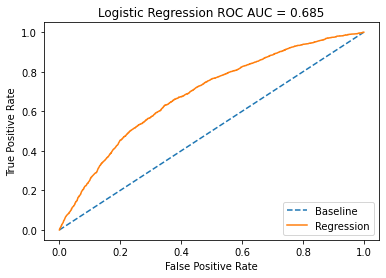

In [37]:
print_roc_curve(y_valid, probs_valid_default)

[[8149 4784]
 [ 638 1189]]
F-1 score: 0.3048717948717949


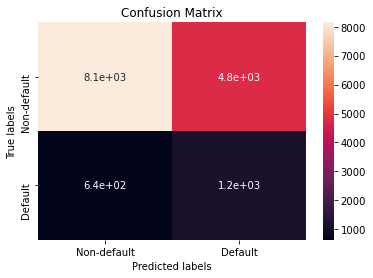

In [38]:
print_confusion_matrix(y_valid, y_pred_valid_values)

**Looks like this model performs approximately the same way when comparing ROC AUC, however it looks significantly better based on f-1 score and confusion matrix. Therefore, let's use this set of hyperparameters for submission**

# Submission

In [39]:
X_train = train.drop('default', axis=1, inplace=False)
y_train = train['default']
X_test = test.drop('default', axis=1, inplace=False)
y_test = test['default']

In [40]:
model_final = LogisticRegression(C=10, penalty='l2', solver='lbfgs', multi_class = 'multinomial', class_weight = 'balanced')
model_final.fit(X_train, y_train)
submit = pd.DataFrame(X_test['client_id'])
X_test.drop('client_id', axis=1, inplace=True)
y_pred = model_final.predict_proba(X_test)
y_predict_proba = y_pred[:,1]
y_predict_values = model_final.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [41]:
submit['default']=y_predict_proba

In [42]:
submit.to_csv('submission.csv', index=False)

In [43]:
submit

,client_id,default
0,74835,0.254761
1,17527,0.603066
2,75683,0.319976
3,26883,0.519964
4,28862,0.350373
...,...,...
36344,83775,0.750093
36345,106254,0.170092
36346,81852,0.539497
36347,1971,0.463649


# Conclusions

1) I definitely managed to improve the original model. Not based on ROC AUC, but based on f1-score and confusion matrix.

2) Unfortunately, I don't have more time to spend on this task. Therefore, the existing score will be my final result.

3) It seems suspicious to me that final model performs better on the dataset where all the numeric variables are removed. I don't know why that happens. Maybe I should have spent more time cleaning numeric variables (removing outliers). I haven't done that because of lack of time.